J. Ruhl, 11/22/2020 <br>
This notebook calculates the loading on dichroic bolometers looking into the room through an NDF.  The intent is to see if we can use a "mild" NDF in combination with a "not-too-high" high-Tc TES for the CMB-S4 LATs, for lab testing. <br>

In [11]:
# imports
import matplotlib.pyplot as plt
import h5py as hp

# physical constants
k = 1.38e-23
c= 2.99792458e8
h = 6.626068e-34

Define the NDF properties here.  Play with the NDF thickness and temperature by hand to make the Lab loading acceptable.  The "room" temperature is set to 450K to allow for looking into a mildly hot load.

In [12]:
# NDF properties
#d_inches = 2.35
#d = d_inches*2.54  # cm

# At 150 use about d=6cm, T_ndf = 3K, to get reasonable loading for 95,150 CHLAT.
d = 0. #cm
T_ndf = 5  #K
T_room = 450 #K

#CR110 material properties, from Halpern etal 1986, Applied Optics, v25, no 4.
# alpha = a*icm**b   
a = 0.3   # for eccosorb CR110 at 4K
b = 1.2   # for eccosorb CR110 at 4K

Define the bands you want to look at.

In [13]:
#Lowedge_20 = 
#Upperedge_20 =
#
Lowedge_30 = 24.0
Upperedge_30 = 30.0
#
Lowedge_40 = 30.0 
Upperedge_40 = 48.0
#
Lowedge_95 = 75.5
Upperedge_95 = 110.0
#
Lowedge_150 = 125.0
Upperedge_150 = 165.0
#
Lowedge_220 = 195.0
Upperedge_220 = 255.0
#
Lowedge_280 = 255.5
Upperedge_280 = 300.0

# CHLAT Popticals
Popt_30 = 0.14
Popt_40 = 0.94
Popt_95 = 1.18 #pW
Popt_150 = 2.5 #pW
Popt_220 = 11.1
Popt_280 = 11.8


In [14]:
# Low band edges
LowBand_lowedge = Lowedge_220
LowBand_upperedge = Upperedge_220

# High band edges
HighBand_lowedge = Lowedge_280
HighBand_upperedge = Upperedge_280

Popt_low = Popt_220
Popt_high = Popt_280

We scale the Popticals (on the science transition, under observing conditions) to the expected Psat for a detector operating on the high-Tc transition.  This scaling depends on 

- the Tc of the upper transition, and 
- the index n of the legs, which is roughly 2.5 to 3.0, and 
- the Psat safety factor relating Poptical to Psat on the science transition.


In [15]:
n = 2.7
Psat_safetyfactor=3.0
Tc_upper = 0.5  #K
Tc_science = 0.16
T_base = 0.1
eta_module = 0.7
#
scalefactor1 = (Tc_upper**n - T_base**n)/(Tc_science**n - T_base**n)
scalefactor = Psat_safetyfactor*scalefactor1
Psat_low_highTc = Popt_low*scalefactor
Psat_high_highTc = Popt_high*scalefactor
print(scalefactor1)

29.76904898108455


We now set up a single frequency vector over which we are going to calculate and plot the NDF transmission and emissivity, and pick elements out of that vector to define the ranges over which we will integrate to find the lower and upper band powers.

In [16]:
# Set up frequency vectors

dnu = 0.1
nu = np.arange(0.8*LowBand_lowedge,1.2*HighBand_upperedge,dnu)   # GHz

ii = np.nonzero(nu>LowBand_lowedge)
jj = np.nonzero(nu<LowBand_upperedge)
lowband_indices = np.intersect1d(ii,jj)
ii = np.nonzero(nu>HighBand_lowedge)
jj = np.nonzero(nu<HighBand_upperedge)
highband_indices = np.intersect1d(ii,jj)

We're going to need a blackbody function, so define it now. This is the power per Hz for a single-mode, single polarization detector;  that is, it is the usual Planck function divided by two (for polarization) and multiplied by $A \Omega = \lambda^2 = (c/\nu)^2$.

In [17]:
def Pnu(T,nu):
    # This returns the power for a single polarization, single-moded, bolo.
    x = (h*nu)/(k*T)
    #B =  1.0*(h*nu)*(nu/c)**2 * (1./(np.exp(x) - 1.))
    # multiply by AOmega = lambda^2 = c^2/nu^2 for a single-mode bolometer
    P = 1.0*(h*nu) * (1./(np.exp(x) - 1.))
    return P

Finally, we can do our calculations.

In [18]:
# Calculate NDF transmission and emissivity, then loading
icm = nu/30 
alpha = a*icm**b   

transmission = np.exp(-alpha*d)
emissivity = 1-transmission

# NDF loading
L2a = eta_module*emissivity[lowband_indices]* Pnu(T_ndf,nu[lowband_indices]*1e9)
H2a = eta_module*emissivity[highband_indices]*Pnu(T_ndf,nu[highband_indices]*1e9)

# Room loading
L2b = eta_module*transmission[lowband_indices]* Pnu(T_room,nu[lowband_indices]*1e9)
H2b = eta_module*transmission[highband_indices]*Pnu(T_room,nu[highband_indices]*1e9)

# Total loading
lbl_2 = np.trapz(L2a,dx=dnu*1e9) + np.trapz(L2b,dx=dnu*1e9)
hbl_2 = np.trapz(H2a,dx=dnu*1e9) + np.trapz(H2b,dx=dnu*1e9)

Report results

NDF (thickness, temp) = 0.00cm, 5.00K
Lower Band Loading
   Popt on sky        : 11.10 pW
   Popt in lab w/ NDF : 257.27 pW
   Psat, on high-Tc   : 991.31 pW

Upper Band Loading
   Popt on sky        : 11.80 pW
   Popt in lab w/ NDF : 190.16 pW
   Psat, on high-Tc   : 1053.82 pW


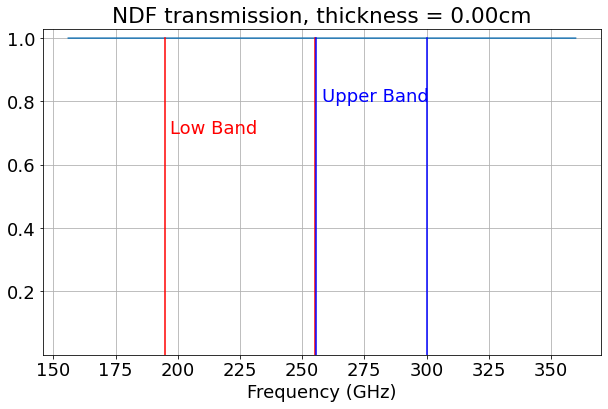

In [22]:
# Plot NDF transmission
miny = 1e-6
maxy = 1
plt.plot(nu,transmission)
plt.plot([LowBand_lowedge,LowBand_lowedge],[miny,maxy],'r')
plt.plot([LowBand_upperedge,LowBand_upperedge],[miny,maxy],'r')
plt.plot([HighBand_lowedge,HighBand_lowedge],[miny,maxy],'b')
plt.plot([HighBand_upperedge,HighBand_upperedge],[miny,maxy],'b')
plt.ylim([miny,1.03*maxy])
plt.grid()
plt.title('NDF transmission, thickness = {0:2.2f}cm'.format(d))
plt.xlabel('Frequency (GHz)')
plt.text(LowBand_lowedge*1.01,0.7*maxy,'Low Band',color='red')
plt.text(HighBand_lowedge*1.01,0.8*maxy,'Upper Band',color='blue')


print('NDF (thickness, temp) = {0:2.2f}cm, {1:2.2f}K'.format(d,T_ndf))
print('Lower Band Loading')
print('   Popt on sky        : {0:2.2f} pW'.format(Popt_low))
print('   Popt in lab w/ NDF : {0:2.2f} pW'.format(lbl_2*1e12))
print('   Psat, on high-Tc   : {0:2.2f} pW'.format(Psat_low_highTc))
print('')
print('Upper Band Loading')
print('   Popt on sky        : {0:2.2f} pW'.format(Popt_high))
print('   Popt in lab w/ NDF : {0:2.2f} pW'.format(hbl_2*1e12))
print('   Psat, on high-Tc   : {0:2.2f} pW'.format(Psat_high_highTc))


3.125